In [1]:
import pylab as plb
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from scipy import signal
import numpy as np
import pandas as pd
import lmfit as lmfit 

In [2]:
cols = ["q", "I"]
data = pd.read_csv("teshi_xs",names=cols)

In [3]:
data

,q,I
0,0.0071,200901.4022
1,0.0072,175225.2432
2,0.0074,162112.5351
3,0.0078,152125.3787
4,0.0081,140467.8535
...,...,...
283,9.3705,0.6161
284,9.5637,0.5133
285,9.8091,0.6553
286,9.8958,0.8730


### Fit using GP model + power law

In [12]:
def GuinierANDPorod(x,A,s,rg,m):
        result=x.copy()
        q2 = 1.0/rg*np.sqrt((m-s)*(3-s)/2)
        B = np.power(q2,m-s)*np.exp((-q2**2*rg**2)/(3-s))
        mask = result<q2
        result[mask] = np.power(x,-s)*np.exp((-x**2*rg**2)/(3-s))
        result[np.invert(mask)] = B*np.power(x,-m)
        return A*result

[66.40901846  1.50279313 14.64271592  4.14778786]
[2.13191984]
q2:  0.09609851492894372  C:  4.747548503132687  B:  0.00054317235738064
Relative diff. @q2:  -0.03682537318879335


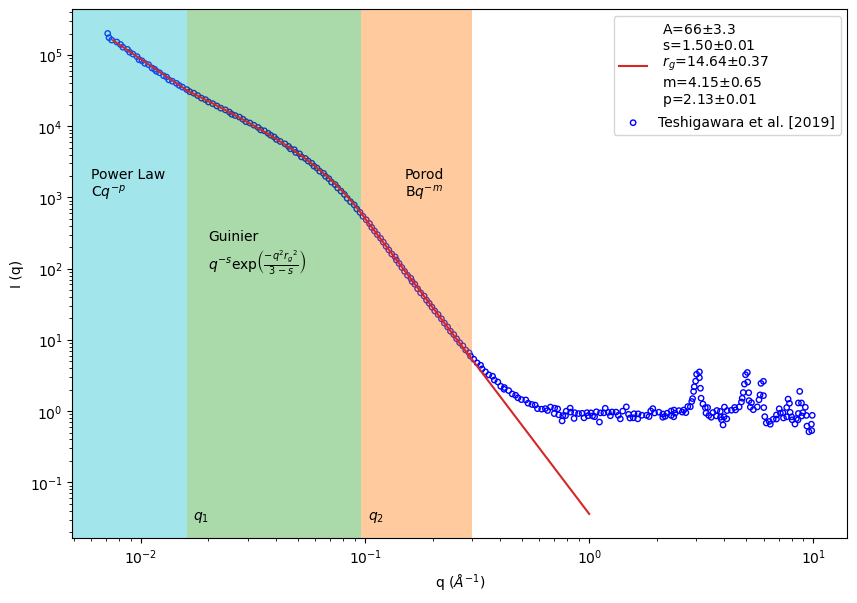

In [35]:
fig, ax = plt.subplots(1,1, figsize=(10, 7), dpi=100)
q1=0.016
mask_fit_PL = (data["q"]>0.0075) & (data["q"]<q1)
mask_fit_guinierANDporod = (data["q"]>q1) & (data["q"]<0.3)

popt,pcov = curve_fit(GuinierANDPorod,
                      data["q"][mask_fit_guinierANDporod],
                      data["I"][mask_fit_guinierANDporod], 
                      p0=[1e2,1.4,16,3.7,],
                      bounds=((0, 1, 0, 3),(np.inf,np.inf,20, 10))
                          )
perr = np.sqrt(np.diag(pcov))
print(popt)

def power_law2(x,p):
    C = popt[0]*np.power(q1,p-popt[1])*np.exp((-q1**2*popt[2]**2)/(3-popt[1]))
    return C*np.power(x,-p)

popt2,pcov2 = curve_fit(power_law2,
                      data["q"][mask_fit_PL],
                      data["I"][mask_fit_PL], 
                      p0=[1],
                      bounds=((0), (np.inf)))
perr2 = np.sqrt(np.diag(pcov2))
print(popt2)

plt.scatter(data["q"],data["I"],s=15,facecolors='none',edgecolors="b",label="Teshigawara et al. [2019]")

x_fit = [x for x in np.linspace(q1,1,1000)]
y_fit=GuinierANDPorod(pd.Series(x_fit),*popt)
x_fit2 =[x for x in np.linspace(0.0075,q1,100)]
y_fit2=power_law2(pd.Series(x_fit2),*popt2)

label_string_GP = f" A={popt[0]:.0f}$\pm${perr[0]:.1f}\n s={popt[1]:.2f}$\pm${perr[1]:.2f}\n $r_g$={popt[2]:.2f}$\pm${perr[2]:.2f}\n m={popt[3]:.2f}$\pm${perr[3]:.2f}\n"
label_string_pl = f" p={popt2[0]:.2f}$\pm${perr2[0]:.2f}"

#Graphical decorators
ymin, ymax = ax.get_ylim()
xmin, xmax = ax.get_xlim()
#plt.vlines(q1,ymin,ymax)
ax.annotate(r'$q_1$',
            xy=(q1+0.001,0.03)
           )
ax.annotate('Power Law\n'+r'C$q^{-p}$', 
            xy=(0.006,1e3)
            )
plt.axvspan(xmin,q1, facecolor='tab:cyan', alpha=0.4)
q2 = 1.0/popt[2]*np.sqrt((popt[3]-popt[1])*(3-popt[1])/2)
B = np.power(q2,popt[3]-popt[1])*np.exp((-q2**2*popt[2]**2)/(3-popt[1]))
C = popt[0]*np.power(q1,popt2[0]-popt[1])*np.exp((-q1**2*popt[2]**2)/(3-popt[1]))
print("q2: ",q2, " C: ",C, " B: ",B)
print("Relative diff. @q2: ",(GuinierANDPorod(pd.Series([0.015]),*popt)[0] - power_law2(pd.Series([0.015]),*popt2)[0])/GuinierANDPorod(pd.Series([0.015]),*popt)[0])
#plt.vlines(q2,ymin,ymax)
ax.annotate("Guinier\n"+r"$q^{-s}\exp\left(\frac{-q^2r{_g}{^2}}{3-s}\right)$", 
            xy=(0.02,1e2)
            )
ax.annotate(f'$q_2$', 
            xy=(q2+0.007,0.03)
            )
plt.axvspan(q1,q2, facecolor='tab:green', alpha=0.4)
plt.axvspan(q2,0.3, facecolor='tab:orange', alpha=0.4)
ax.annotate('Porod\n'+r'B$q^{-m}$', 
            xy=(0.15,1e3)
            )


plt.plot(x_fit,y_fit, c="tab:red", label=label_string_GP+label_string_pl)
plt.plot(x_fit2,y_fit2, c="tab:red",label=None)
plt.legend()
plt.xscale("log")
plt.xlabel("q ($Å^{-1}$)")
plt.ylabel("I (q)")
plt.yscale("log")
#plt.grid(ls=":",which="both")
plt.show()

### Residual

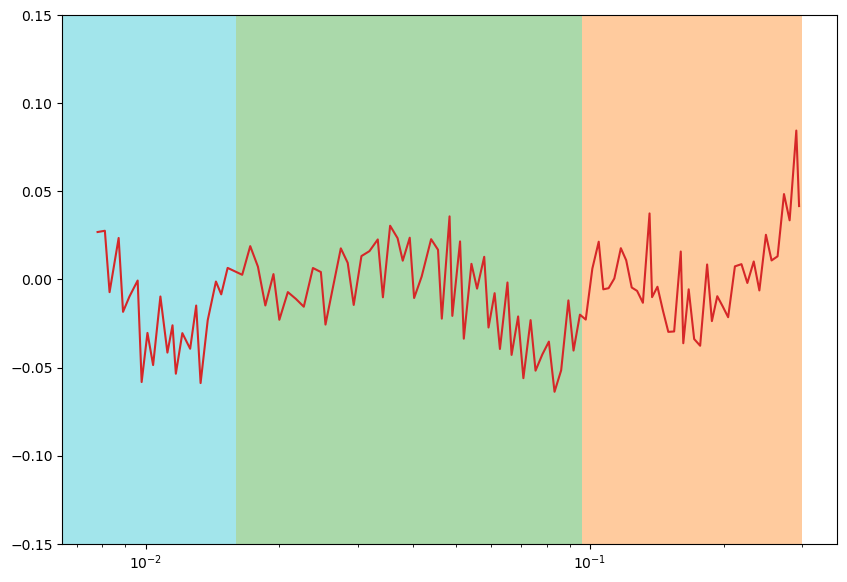

In [38]:
fig, ax = plt.subplots(1,1, figsize=(10, 7), dpi=100)

residual_GP = (data["I"][mask_fit_guinierANDporod] - GuinierANDPorod(data["q"][mask_fit_guinierANDporod],*popt))/data["I"][mask_fit_guinierANDporod]
residual_pl = (data["I"][mask_fit_PL] - power_law2(data["q"][mask_fit_PL],*popt2))/data["I"][mask_fit_PL]

plt.plot(pd.concat([data["q"][mask_fit_PL],data["q"][mask_fit_guinierANDporod]]),pd.concat([residual_pl,residual_GP]), c="tab:red")
xmin, xmax = ax.get_xlim()
plt.axvspan(xmin,q1, facecolor='tab:cyan', alpha=0.4)
plt.axvspan(q1,q2, facecolor='tab:green', alpha=0.4)
plt.axvspan(q2,0.3, facecolor='tab:orange', alpha=0.4)
plt.ylim(-0.15,0.15)
plt.xscale("log")

### Fit only GP

[66.40901846  1.50279313 14.64271592  4.14778786]
q2:  0.09609851492894372  B:  0.00054317235738064


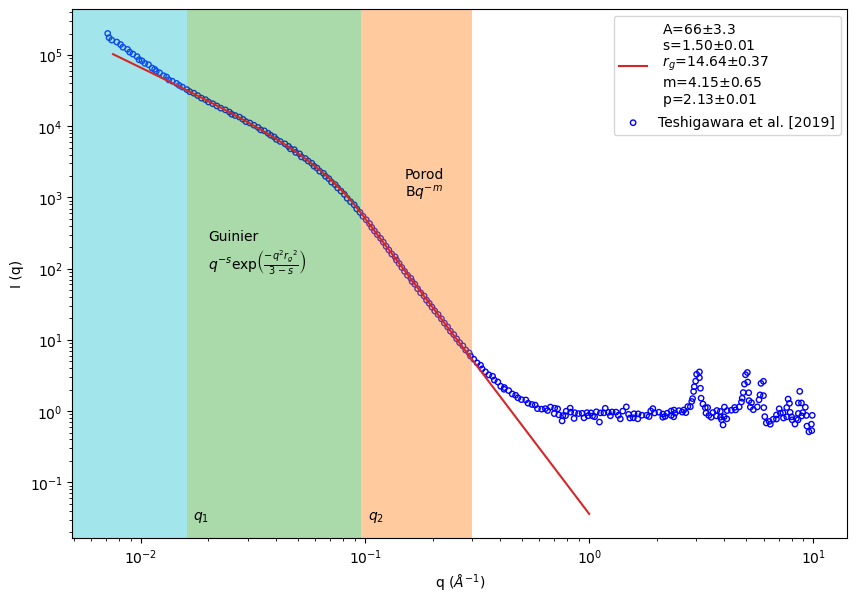

In [36]:
fig, ax = plt.subplots(1,1, figsize=(10, 7), dpi=100)
q1=0.016
mask_fit_PL = (data["q"]>0.0075) & (data["q"]<q1)
mask_fit_guinierANDporod = (data["q"]>q1) & (data["q"]<0.3)

popt,pcov = curve_fit(GuinierANDPorod,
                      data["q"][mask_fit_guinierANDporod],
                      data["I"][mask_fit_guinierANDporod], 
                      p0=[1e2,1.4,16,3.7,],
                      bounds=((0, 1, 0, 3),(np.inf,np.inf,20, 10))
                          )
perr = np.sqrt(np.diag(pcov))
print(popt)

plt.scatter(data["q"],data["I"],s=15,facecolors='none',edgecolors="b",label="Teshigawara et al. [2019]")

x_fit = [x for x in np.linspace(0.0075,1,1000)]
y_fit=GuinierANDPorod(pd.Series(x_fit),*popt)

label_string_GP = f" A={popt[0]:.0f}$\pm${perr[0]:.1f}\n s={popt[1]:.2f}$\pm${perr[1]:.2f}\n $r_g$={popt[2]:.2f}$\pm${perr[2]:.2f}\n m={popt[3]:.2f}$\pm${perr[3]:.2f}\n"

#Graphical decorators
ymin, ymax = ax.get_ylim()
xmin, xmax = ax.get_xlim()
#plt.vlines(q1,ymin,ymax)
ax.annotate(r'$q_1$',
            xy=(q1+0.001,0.03)
           )
plt.axvspan(xmin,q1, facecolor='tab:cyan', alpha=0.4)
q2 = 1.0/popt[2]*np.sqrt((popt[3]-popt[1])*(3-popt[1])/2)
B = np.power(q2,popt[3]-popt[1])*np.exp((-q2**2*popt[2]**2)/(3-popt[1]))
print("q2: ",q2, " B: ",B)
#plt.vlines(q2,ymin,ymax)
ax.annotate("Guinier\n"+r"$q^{-s}\exp\left(\frac{-q^2r{_g}{^2}}{3-s}\right)$", 
            xy=(0.02,1e2)
            )
ax.annotate(f'$q_2$', 
            xy=(q2+0.007,0.03)
            )
plt.axvspan(q1,q2, facecolor='tab:green', alpha=0.4)
plt.axvspan(q2,0.3, facecolor='tab:orange', alpha=0.4)
ax.annotate('Porod\n'+r'B$q^{-m}$', 
            xy=(0.15,1e3)
            )


plt.plot(x_fit,y_fit, c="tab:red", label=label_string_GP+label_string_pl)
#plt.plot(x_fit2,y_fit2, c="tab:red",label=None)
plt.legend()
plt.xscale("log")
plt.xlabel("q ($Å^{-1}$)")
plt.ylabel("I (q)")
plt.yscale("log")
#plt.grid(ls=":",which="both")
plt.show()

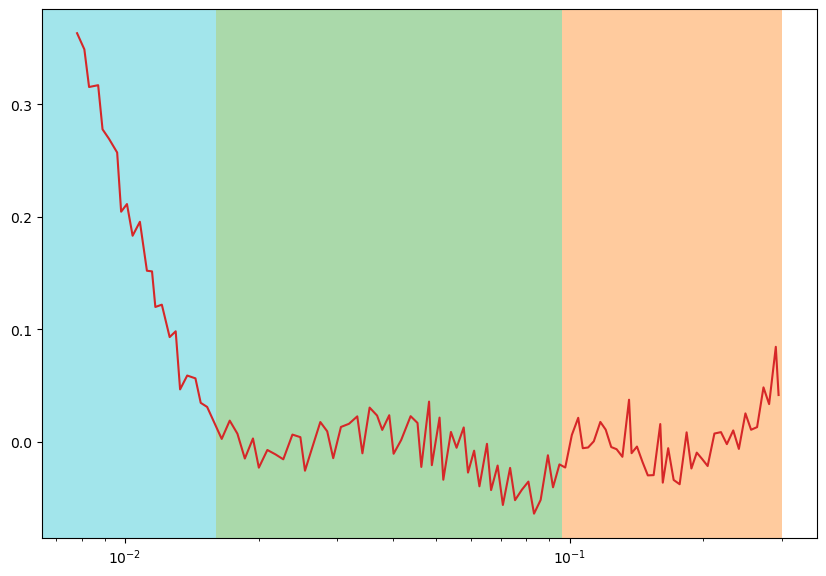

In [37]:
fig, ax = plt.subplots(1,1, figsize=(10, 7), dpi=100)

residual_GP = (data["I"][mask_fit_guinierANDporod] - GuinierANDPorod(data["q"][mask_fit_guinierANDporod],*popt))/data["I"][mask_fit_guinierANDporod]
residual_pl = (data["I"][mask_fit_PL] - GuinierANDPorod(data["q"][mask_fit_PL],*popt))/data["I"][mask_fit_PL]

plt.plot(pd.concat([data["q"][mask_fit_PL],data["q"][mask_fit_guinierANDporod]]),pd.concat([residual_pl,residual_GP]), c="tab:red")
xmin, xmax = ax.get_xlim()
plt.axvspan(xmin,q1, facecolor='tab:cyan', alpha=0.4)
plt.axvspan(q1,q2, facecolor='tab:green', alpha=0.4)
plt.axvspan(q2,0.3, facecolor='tab:orange', alpha=0.4)
#plt.ylim(-0.15,0.15)
plt.xscale("log")

### OLD